# PES of Hydrogen Molecule (Hartree-Fock Only) With Various IBMQ Noise and Mitiq

Here we repeat the same code from 3_1B, but only with a Hartree-Fock State $|1100\rangle$. We remove all quantum gates related to the Disentangled UCC Ansatz.

In [1]:
# Native Lib
import itertools as it
import json
import time

# External Lib
import qiskit
import numpy as np
import pennylane as qml
from pennylane import numpy as plnp
import matplotlib.pyplot as plt
from qiskit.providers.aer.noise import NoiseModel
from mitiq.zne.scaling import fold_global
from mitiq.zne import execute_with_zne

# qanything Lib
import qanything.common_functions as cf
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

### Load IBM Noise Model Devices

In [2]:
# Start IBMQ
qiskit.IBMQ.load_account()

# # Get a list of backends
# backend_list = []
# for b in provider.backends():
#     backend_list.append(b.name())

# Filtered Backend List
backend_list = ['ibmq_montreal',
                'ibmq_toronto',
                'ibmq_santiago',
                'ibmq_bogota',
                'ibmq_casablanca',
                'ibmq_mumbai',
                'ibmq_lima',
                'ibmq_belem',
                'ibmq_quito',
                'ibmq_guadalupe',
                'ibmq_brooklyn',
                'ibmq_jakarta',
                'ibmq_manila',
                'ibm_hanoi',
                'ibm_lagos',
                'ibm_cairo',
                'ibm_auckland',
                'ibm_perth',
                'ibm_washington']

In [4]:
# Load Results from Geometry Optimisation Hydrogen
h2_opt_data_filename = 'h2_morse_vqe.json'
h2_opt_data = getjson.load_from_json(h2_opt_data_filename)

Loading Data from: h2_morse_vqe.json


### Apply IBM Noise Models and Perform Noise Zero Extrapolation (NZE) (ONLY Hydrogen Molecule Hartree-Fock State)

In [5]:
# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'

# Get Hamiltonian
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, h2_opt_data['bond_length'][0])
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    # for i, excitation in enumerate(excitations):
    #     if len(excitation) == 4:
    #         qml.DoubleExcitation(params[i], wires=excitation)
    #     else:
    #         qml.SingleExcitation(params[i], wires=excitation)

# We shall remove all single excitation and only consider the double excitation. 
disentangle_order_only_doubles = [[0, 1, 2, 3]] 

# Maximum Number of Shots available on IBMQ
num_shots = 20000
noisy_backend_noisy_morse = []
mitig_noisy_backend_noisy_morse = []
for i in range(len(backend_list)):

    print(f'\nCurrent Backend: {backend_list[i]}')
    backend = provider.get_backend(backend_list[i])
    noise_model = NoiseModel.from_backend(backend)
    dev = qml.device('qiskit.aer', wires=num_qubits, backend= 'aer_simulator', noise_model=noise_model, shots = num_shots)

    # Loop through all bond lengths and get the noisy energy.
    noisy_morse = []
    mitig_noisy_morse = []
    for j in range(len(h2_opt_data['bond_length'])):

        # Get Hydrogen Molecule Hamiltonian with new bond length
        bond_length = h2_opt_data['bond_length'][j]
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

        # Get only double excitation rotation angle and perform only double excitation 
        params = [h2_opt_data['vqe_params'][j][2]]
        cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=False)
        noisy_energy = cost_fn(params, excitations=disentangle_order_only_doubles)
        noisy_morse.append(noisy_energy)
        print("Bond Length: %.1f, Noisy Energy: %.5f" %(bond_length, noisy_energy))

        # Construct my Quantum Circuit
        with qml.tape.QuantumTape() as circuit:
            qml.PauliX(wires=0)
            qml.PauliX(wires=1)

            # Get only double excitation rotation angle and perform only double excitation 
            # params = [h2_opt_data['vqe_params'][j][2]]
            # for k, excitation in enumerate(disentangle_order_only_doubles):
            #     if len(excitation) == 4:
            #         qml.DoubleExcitation(params[k], wires=excitation)
            #     else:
            #         qml.SingleExcitation(params[k], wires=excitation)
        
        # Define custom executor that expands Hamiltonian measurement into a linear combination of tensor products of Pauli operators.
        def executor(circuit):

            # Add Hamiltonian measurement to circuit
            with qml.tape.QuantumTape() as circuit_with_meas:
                for o in circuit.operations:
                    qml.apply(o)
                qml.expval(mol_ham)

            # Expand Hamiltonian measurement into tensor product of Pauli operators. We get a list of circuits to execute and a postprocessing function to combine the results into a single number.
            circuits, postproc = qml.transforms.hamiltonian_expand(circuit_with_meas, group=False)
            circuits_executed = qml.execute(circuits, dev, gradient_fn=None)
            return postproc(circuits_executed)

        mitig_energy = execute_with_zne(circuit, executor, scale_noise=fold_global)
        mitig_noisy_morse.append(mitig_energy)

        print("Bond Length: %.1f, Mitig Noisy Energy: %.5f" %(bond_length, mitig_energy))

    mitig_noisy_backend_noisy_morse.append(mitig_noisy_morse)
    noisy_backend_noisy_morse.append(noisy_morse)

/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'



Current Backend: ibmq_montreal
Bond Length: 1.0, Noisy Energy: -1.02625


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -1.02777
Bond Length: 1.2, Noisy Energy: -1.07784


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.07987
Bond Length: 1.4, Noisy Energy: -1.08617


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.08520
Bond Length: 1.6, Noisy Energy: -1.07599


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.07790
Bond Length: 1.8, Noisy Energy: -1.05500


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.05260
Bond Length: 2.0, Noisy Energy: -1.02908


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.03212
Bond Length: 2.2, Noisy Energy: -0.99862


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.99424
Bond Length: 2.4, Noisy Energy: -0.96463


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.96530
Bond Length: 2.6, Noisy Energy: -0.93106


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.93596
Bond Length: 2.8, Noisy Energy: -0.90300


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.89842
Bond Length: 3.0, Noisy Energy: -0.87125


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.86179
Bond Length: 3.2, Noisy Energy: -0.84300


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.84433
Bond Length: 3.4, Noisy Energy: -0.81536


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.82057
Bond Length: 3.6, Noisy Energy: -0.79178


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.79346
Bond Length: 3.8, Noisy Energy: -0.77219


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76905
Bond Length: 4.0, Noisy Energy: -0.74878


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75541

Current Backend: ibmq_toronto
Bond Length: 1.0, Noisy Energy: -0.89702


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.87765
Bond Length: 1.2, Noisy Energy: -0.96103


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -0.96057
Bond Length: 1.4, Noisy Energy: -0.98516


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -0.98817
Bond Length: 1.6, Noisy Energy: -0.98182


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -0.98178
Bond Length: 1.8, Noisy Energy: -0.96796


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -0.97822
Bond Length: 2.0, Noisy Energy: -0.94979


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.94595
Bond Length: 2.2, Noisy Energy: -0.92627


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.93432
Bond Length: 2.4, Noisy Energy: -0.90141


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.90407
Bond Length: 2.6, Noisy Energy: -0.87191


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.86927
Bond Length: 2.8, Noisy Energy: -0.84639


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.85094
Bond Length: 3.0, Noisy Energy: -0.82157


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.82310
Bond Length: 3.2, Noisy Energy: -0.79488


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.81611
Bond Length: 3.4, Noisy Energy: -0.77159


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.77360
Bond Length: 3.6, Noisy Energy: -0.75463


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.75139
Bond Length: 3.8, Noisy Energy: -0.73555


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.72876
Bond Length: 4.0, Noisy Energy: -0.71629


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.71761

Current Backend: ibmq_santiago


Bond Length: 1.0, Noisy Energy: -0.91568


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.91046
Bond Length: 1.2, Noisy Energy: -0.98021


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -0.97601
Bond Length: 1.4, Noisy Energy: -1.00736


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.01068
Bond Length: 1.6, Noisy Energy: -1.01036


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.00532
Bond Length: 1.8, Noisy Energy: -0.99839


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -0.99027
Bond Length: 2.0, Noisy Energy: -0.97747


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.98983
Bond Length: 2.2, Noisy Energy: -0.95191


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.95680
Bond Length: 2.4, Noisy Energy: -0.92823


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.93128
Bond Length: 2.6, Noisy Energy: -0.90349


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.90243
Bond Length: 2.8, Noisy Energy: -0.87354


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.87380
Bond Length: 3.0, Noisy Energy: -0.84791


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.84937
Bond Length: 3.2, Noisy Energy: -0.82432


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.82760
Bond Length: 3.4, Noisy Energy: -0.79980


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79482
Bond Length: 3.6, Noisy Energy: -0.77874


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.77426
Bond Length: 3.8, Noisy Energy: -0.75953


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.75663
Bond Length: 4.0, Noisy Energy: -0.74140


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75053

Current Backend: ibmq_bogota
Bond Length: 1.0, Noisy Energy: -0.92771


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.94124
Bond Length: 1.2, Noisy Energy: -0.98824


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -0.98164
Bond Length: 1.4, Noisy Energy: -1.00337


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -0.99886
Bond Length: 1.6, Noisy Energy: -0.99943


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.00338
Bond Length: 1.8, Noisy Energy: -0.98176


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -0.98210
Bond Length: 2.0, Noisy Energy: -0.95711


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.94973
Bond Length: 2.2, Noisy Energy: -0.93311


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.93949
Bond Length: 2.4, Noisy Energy: -0.90798


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.90746
Bond Length: 2.6, Noisy Energy: -0.87634


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.88887
Bond Length: 2.8, Noisy Energy: -0.85051


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.84475
Bond Length: 3.0, Noisy Energy: -0.82349


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.83272
Bond Length: 3.2, Noisy Energy: -0.79691


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.79346
Bond Length: 3.4, Noisy Energy: -0.77557


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.76889
Bond Length: 3.6, Noisy Energy: -0.75284


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.74781
Bond Length: 3.8, Noisy Energy: -0.73324


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.74113
Bond Length: 4.0, Noisy Energy: -0.71466


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.72477

Current Backend: ibmq_casablanca
Bond Length: 1.0, Noisy Energy: -0.97604


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.98144
Bond Length: 1.2, Noisy Energy: -1.03216


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.01905
Bond Length: 1.4, Noisy Energy: -1.04324


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.04379
Bond Length: 1.6, Noisy Energy: -1.03635


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.02359
Bond Length: 1.8, Noisy Energy: -1.01507


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.02436
Bond Length: 2.0, Noisy Energy: -0.99303


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.99478
Bond Length: 2.2, Noisy Energy: -0.96350


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.96922
Bond Length: 2.4, Noisy Energy: -0.93626


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.92660
Bond Length: 2.6, Noisy Energy: -0.90602


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.90682
Bond Length: 2.8, Noisy Energy: -0.87670


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88456
Bond Length: 3.0, Noisy Energy: -0.84601


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.85060
Bond Length: 3.2, Noisy Energy: -0.82154


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.81397
Bond Length: 3.4, Noisy Energy: -0.79403


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.80167
Bond Length: 3.6, Noisy Energy: -0.77334


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78491
Bond Length: 3.8, Noisy Energy: -0.75345


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76246
Bond Length: 4.0, Noisy Energy: -0.73602


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.72696

Current Backend: ibmq_mumbai


Bond Length: 1.0, Noisy Energy: -1.00110


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.99484
Bond Length: 1.2, Noisy Energy: -1.04854


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.03966
Bond Length: 1.4, Noisy Energy: -1.06726


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.05590
Bond Length: 1.6, Noisy Energy: -1.05196


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.05052
Bond Length: 1.8, Noisy Energy: -1.03153


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.02995
Bond Length: 2.0, Noisy Energy: -1.00783


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.01088
Bond Length: 2.2, Noisy Energy: -0.97711


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.96539
Bond Length: 2.4, Noisy Energy: -0.94659


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94580
Bond Length: 2.6, Noisy Energy: -0.91709


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91833
Bond Length: 2.8, Noisy Energy: -0.88335


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88321
Bond Length: 3.0, Noisy Energy: -0.85599


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.85569
Bond Length: 3.2, Noisy Energy: -0.83051


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.83467
Bond Length: 3.4, Noisy Energy: -0.80213


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79970
Bond Length: 3.6, Noisy Energy: -0.78144


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78017
Bond Length: 3.8, Noisy Energy: -0.76015


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76788
Bond Length: 4.0, Noisy Energy: -0.73956


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.74116

Current Backend: ibmq_lima
Bond Length: 1.0, Noisy Energy: -0.99176


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.98488
Bond Length: 1.2, Noisy Energy: -1.04156


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.04590
Bond Length: 1.4, Noisy Energy: -1.05175


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.06525
Bond Length: 1.6, Noisy Energy: -1.04634


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.03622
Bond Length: 1.8, Noisy Energy: -1.02770


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.02819
Bond Length: 2.0, Noisy Energy: -1.00534


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.99785
Bond Length: 2.2, Noisy Energy: -0.97296


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97335
Bond Length: 2.4, Noisy Energy: -0.94258


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.95305
Bond Length: 2.6, Noisy Energy: -0.91138


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91087
Bond Length: 2.8, Noisy Energy: -0.88050


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88259
Bond Length: 3.0, Noisy Energy: -0.85174


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.86245
Bond Length: 3.2, Noisy Energy: -0.82913


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.83176
Bond Length: 3.4, Noisy Energy: -0.80240


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.78736
Bond Length: 3.6, Noisy Energy: -0.77723


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.77368
Bond Length: 3.8, Noisy Energy: -0.75740


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.75444
Bond Length: 4.0, Noisy Energy: -0.73921


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73761

Current Backend: ibmq_belem
Bond Length: 1.0, Noisy Energy: -0.98670


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.98931
Bond Length: 1.2, Noisy Energy: -1.03825


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.03096
Bond Length: 1.4, Noisy Energy: -1.05336


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.05509
Bond Length: 1.6, Noisy Energy: -1.04638


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.04484
Bond Length: 1.8, Noisy Energy: -1.02874


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.02230
Bond Length: 2.0, Noisy Energy: -1.00258


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.00435
Bond Length: 2.2, Noisy Energy: -0.97323


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97449
Bond Length: 2.4, Noisy Energy: -0.94401


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94020
Bond Length: 2.6, Noisy Energy: -0.91331


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91436
Bond Length: 2.8, Noisy Energy: -0.88465


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88510
Bond Length: 3.0, Noisy Energy: -0.85602


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.84918
Bond Length: 3.2, Noisy Energy: -0.83040


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.83562
Bond Length: 3.4, Noisy Energy: -0.80356


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79924
Bond Length: 3.6, Noisy Energy: -0.78187


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78177
Bond Length: 3.8, Noisy Energy: -0.76042


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76267
Bond Length: 4.0, Noisy Energy: -0.74058


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73192

Current Backend: ibmq_quito
Bond Length: 1.0, Noisy Energy: -0.99155


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.99494
Bond Length: 1.2, Noisy Energy: -1.04323


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.03528
Bond Length: 1.4, Noisy Energy: -1.05762


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.05440
Bond Length: 1.6, Noisy Energy: -1.04593


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.04037
Bond Length: 1.8, Noisy Energy: -1.02876


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.03264
Bond Length: 2.0, Noisy Energy: -1.00193


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.99663
Bond Length: 2.2, Noisy Energy: -0.97350


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97553
Bond Length: 2.4, Noisy Energy: -0.94175


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.95692
Bond Length: 2.6, Noisy Energy: -0.91260


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.92347
Bond Length: 2.8, Noisy Energy: -0.88513


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88865
Bond Length: 3.0, Noisy Energy: -0.85536


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.85285
Bond Length: 3.2, Noisy Energy: -0.82533


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.82896
Bond Length: 3.4, Noisy Energy: -0.80100


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79810
Bond Length: 3.6, Noisy Energy: -0.77910


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.77974
Bond Length: 3.8, Noisy Energy: -0.75708


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.75174
Bond Length: 4.0, Noisy Energy: -0.73836


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73196

Current Backend: ibmq_guadalupe
Bond Length: 1.0, Noisy Energy: -0.88794


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.88090
Bond Length: 1.2, Noisy Energy: -0.95418


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -0.95572
Bond Length: 1.4, Noisy Energy: -0.97840


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -0.98998
Bond Length: 1.6, Noisy Energy: -0.98577


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -0.98123
Bond Length: 1.8, Noisy Energy: -0.97626


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -0.97474
Bond Length: 2.0, Noisy Energy: -0.96028


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.97579
Bond Length: 2.2, Noisy Energy: -0.93435


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.93999
Bond Length: 2.4, Noisy Energy: -0.91262


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.91281
Bond Length: 2.6, Noisy Energy: -0.88492


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.89022
Bond Length: 2.8, Noisy Energy: -0.85835


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.86394
Bond Length: 3.0, Noisy Energy: -0.83391


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.82546
Bond Length: 3.2, Noisy Energy: -0.80898


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.81027
Bond Length: 3.4, Noisy Energy: -0.78984


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.78278
Bond Length: 3.6, Noisy Energy: -0.76893


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.76262
Bond Length: 3.8, Noisy Energy: -0.74784


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.73755
Bond Length: 4.0, Noisy Energy: -0.73005


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73607

Current Backend: ibmq_brooklyn
Bond Length: 1.0, Noisy Energy: -0.99151


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.99515
Bond Length: 1.2, Noisy Energy: -1.04534


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.04583
Bond Length: 1.4, Noisy Energy: -1.06034


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.04843
Bond Length: 1.6, Noisy Energy: -1.05162


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.04610
Bond Length: 1.8, Noisy Energy: -1.03493


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.03286
Bond Length: 2.0, Noisy Energy: -1.00439


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.01135
Bond Length: 2.2, Noisy Energy: -0.97895


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97210
Bond Length: 2.4, Noisy Energy: -0.95022


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94497
Bond Length: 2.6, Noisy Energy: -0.92034


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91612
Bond Length: 2.8, Noisy Energy: -0.88825


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.89109
Bond Length: 3.0, Noisy Energy: -0.85786


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.86107
Bond Length: 3.2, Noisy Energy: -0.83379


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.82349
Bond Length: 3.4, Noisy Energy: -0.80748


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79446
Bond Length: 3.6, Noisy Energy: -0.78217


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.77610
Bond Length: 3.8, Noisy Energy: -0.76162


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76457
Bond Length: 4.0, Noisy Energy: -0.74373


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.74021

Current Backend: ibmq_jakarta
Bond Length: 1.0, Noisy Energy: -0.99290


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.97748
Bond Length: 1.2, Noisy Energy: -1.04890


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.04119
Bond Length: 1.4, Noisy Energy: -1.05883


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.05275
Bond Length: 1.6, Noisy Energy: -1.04860


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.05288
Bond Length: 1.8, Noisy Energy: -1.03248


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.02442
Bond Length: 2.0, Noisy Energy: -1.00660


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.99821
Bond Length: 2.2, Noisy Energy: -0.97403


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97604
Bond Length: 2.4, Noisy Energy: -0.94536


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94023
Bond Length: 2.6, Noisy Energy: -0.91408


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91270
Bond Length: 2.8, Noisy Energy: -0.88252


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88418
Bond Length: 3.0, Noisy Energy: -0.85404


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.84744
Bond Length: 3.2, Noisy Energy: -0.82928


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.82994
Bond Length: 3.4, Noisy Energy: -0.80380


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.81085
Bond Length: 3.6, Noisy Energy: -0.78144


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78503
Bond Length: 3.8, Noisy Energy: -0.76042


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.75510
Bond Length: 4.0, Noisy Energy: -0.74011


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73826

Current Backend: ibmq_manila
Bond Length: 1.0, Noisy Energy: -0.99827


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.99617
Bond Length: 1.2, Noisy Energy: -1.05103


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.04625
Bond Length: 1.4, Noisy Energy: -1.06235


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.05727
Bond Length: 1.6, Noisy Energy: -1.05469


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.05554
Bond Length: 1.8, Noisy Energy: -1.03540


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.03706
Bond Length: 2.0, Noisy Energy: -1.00958


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.00151
Bond Length: 2.2, Noisy Energy: -0.98095


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.97135
Bond Length: 2.4, Noisy Energy: -0.95192


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.95220
Bond Length: 2.6, Noisy Energy: -0.92089


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91390
Bond Length: 2.8, Noisy Energy: -0.88896


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.89040
Bond Length: 3.0, Noisy Energy: -0.85899


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.86178
Bond Length: 3.2, Noisy Energy: -0.83303


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.83584
Bond Length: 3.4, Noisy Energy: -0.80793


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.80904
Bond Length: 3.6, Noisy Energy: -0.78467


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.79776
Bond Length: 3.8, Noisy Energy: -0.76542


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76702
Bond Length: 4.0, Noisy Energy: -0.74518


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.73546

Current Backend: ibm_hanoi
Bond Length: 1.0, Noisy Energy: -1.04177


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -1.04509
Bond Length: 1.2, Noisy Energy: -1.09063


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.08795
Bond Length: 1.4, Noisy Energy: -1.09863


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.09694
Bond Length: 1.6, Noisy Energy: -1.08422


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.08873
Bond Length: 1.8, Noisy Energy: -1.06358


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.06173
Bond Length: 2.0, Noisy Energy: -1.03519


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.03003
Bond Length: 2.2, Noisy Energy: -1.00441


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -1.00157
Bond Length: 2.4, Noisy Energy: -0.96968


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.96602
Bond Length: 2.6, Noisy Energy: -0.93775


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.93790
Bond Length: 2.8, Noisy Energy: -0.90447


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.90824
Bond Length: 3.0, Noisy Energy: -0.87535


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.87345
Bond Length: 3.2, Noisy Energy: -0.84802


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.84109
Bond Length: 3.4, Noisy Energy: -0.82050


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.82466
Bond Length: 3.6, Noisy Energy: -0.79715


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78942
Bond Length: 3.8, Noisy Energy: -0.77276


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76923
Bond Length: 4.0, Noisy Energy: -0.75515


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75551

Current Backend: ibm_lagos
Bond Length: 1.0, Noisy Energy: -1.03112


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -1.03622
Bond Length: 1.2, Noisy Energy: -1.07826


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.06979
Bond Length: 1.4, Noisy Energy: -1.08878


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.09240
Bond Length: 1.6, Noisy Energy: -1.07740


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.07367
Bond Length: 1.8, Noisy Energy: -1.05644


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.05421
Bond Length: 2.0, Noisy Energy: -1.03034


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.03041
Bond Length: 2.2, Noisy Energy: -0.99888


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.99033
Bond Length: 2.4, Noisy Energy: -0.96553


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.97938
Bond Length: 2.6, Noisy Energy: -0.93564


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.93933
Bond Length: 2.8, Noisy Energy: -0.90210


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.89462
Bond Length: 3.0, Noisy Energy: -0.87303


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.86657
Bond Length: 3.2, Noisy Energy: -0.84351


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.84538
Bond Length: 3.4, Noisy Energy: -0.81852


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.82100
Bond Length: 3.6, Noisy Energy: -0.79441


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.79834
Bond Length: 3.8, Noisy Energy: -0.77266


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.77161
Bond Length: 4.0, Noisy Energy: -0.75327


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75783

Current Backend: ibm_cairo


Bond Length: 1.0, Noisy Energy: -1.02555


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -1.02812
Bond Length: 1.2, Noisy Energy: -1.07436


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.07059
Bond Length: 1.4, Noisy Energy: -1.08337


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.08154
Bond Length: 1.6, Noisy Energy: -1.07288


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.07988
Bond Length: 1.8, Noisy Energy: -1.05251


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.04606
Bond Length: 2.0, Noisy Energy: -1.02472


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.02792
Bond Length: 2.2, Noisy Energy: -0.99477


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.99545
Bond Length: 2.4, Noisy Energy: -0.96239


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.95597
Bond Length: 2.6, Noisy Energy: -0.92801


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.92385
Bond Length: 2.8, Noisy Energy: -0.90018


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.90357
Bond Length: 3.0, Noisy Energy: -0.86967


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.87267
Bond Length: 3.2, Noisy Energy: -0.84027


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.84078
Bond Length: 3.4, Noisy Energy: -0.81608


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.81587
Bond Length: 3.6, Noisy Energy: -0.79055


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.79942
Bond Length: 3.8, Noisy Energy: -0.77065


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.77309
Bond Length: 4.0, Noisy Energy: -0.75028


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75249

Current Backend: ibm_auckland
Bond Length: 1.0, Noisy Energy: -1.03847


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -1.04174
Bond Length: 1.2, Noisy Energy: -1.08732


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.08798
Bond Length: 1.4, Noisy Energy: -1.09601


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.09550
Bond Length: 1.6, Noisy Energy: -1.08488


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.08476
Bond Length: 1.8, Noisy Energy: -1.06411


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.06041
Bond Length: 2.0, Noisy Energy: -1.03425


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.03831
Bond Length: 2.2, Noisy Energy: -1.00200


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -1.00780
Bond Length: 2.4, Noisy Energy: -0.97083


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.96963
Bond Length: 2.6, Noisy Energy: -0.93759


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.93296
Bond Length: 2.8, Noisy Energy: -0.90639


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.89798
Bond Length: 3.0, Noisy Energy: -0.87822


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.87522
Bond Length: 3.2, Noisy Energy: -0.84842


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.85117
Bond Length: 3.4, Noisy Energy: -0.82319


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.82340
Bond Length: 3.6, Noisy Energy: -0.79802


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.80027
Bond Length: 3.8, Noisy Energy: -0.77458


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.77975
Bond Length: 4.0, Noisy Energy: -0.75584


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75723

Current Backend: ibm_perth
Bond Length: 1.0, Noisy Energy: -0.95167


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.96133
Bond Length: 1.2, Noisy Energy: -1.01283


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.00427
Bond Length: 1.4, Noisy Energy: -1.03476


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.03153
Bond Length: 1.6, Noisy Energy: -1.02992


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.02993
Bond Length: 1.8, Noisy Energy: -1.01603


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.01075
Bond Length: 2.0, Noisy Energy: -0.99523


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -0.99961
Bond Length: 2.2, Noisy Energy: -0.96692


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.96144
Bond Length: 2.4, Noisy Energy: -0.93556


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94191
Bond Length: 2.6, Noisy Energy: -0.90594


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.90572
Bond Length: 2.8, Noisy Energy: -0.88114


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88858
Bond Length: 3.0, Noisy Energy: -0.85544


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.85272
Bond Length: 3.2, Noisy Energy: -0.82715


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.82077
Bond Length: 3.4, Noisy Energy: -0.80412


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.79870
Bond Length: 3.6, Noisy Energy: -0.78307


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.76901
Bond Length: 3.8, Noisy Energy: -0.75899


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.75705
Bond Length: 4.0, Noisy Energy: -0.74314


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.74473

Current Backend: ibm_washington


Bond Length: 1.0, Noisy Energy: -0.97839


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.0, Mitig Noisy Energy: -0.98525
Bond Length: 1.2, Noisy Energy: -1.03812


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.2, Mitig Noisy Energy: -1.03504
Bond Length: 1.4, Noisy Energy: -1.04866


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.4, Mitig Noisy Energy: -1.04766
Bond Length: 1.6, Noisy Energy: -1.04629


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.6, Mitig Noisy Energy: -1.05303
Bond Length: 1.8, Noisy Energy: -1.02815


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 1.8, Mitig Noisy Energy: -1.03038
Bond Length: 2.0, Noisy Energy: -1.00504


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.0, Mitig Noisy Energy: -1.00986
Bond Length: 2.2, Noisy Energy: -0.97595


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.2, Mitig Noisy Energy: -0.98395
Bond Length: 2.4, Noisy Energy: -0.94651


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.4, Mitig Noisy Energy: -0.94957
Bond Length: 2.6, Noisy Energy: -0.91854


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.6, Mitig Noisy Energy: -0.91756
Bond Length: 2.8, Noisy Energy: -0.88751


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 2.8, Mitig Noisy Energy: -0.88566
Bond Length: 3.0, Noisy Energy: -0.85918


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.0, Mitig Noisy Energy: -0.84644
Bond Length: 3.2, Noisy Energy: -0.83266


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.2, Mitig Noisy Energy: -0.83264
Bond Length: 3.4, Noisy Energy: -0.80614


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.4, Mitig Noisy Energy: -0.81547
Bond Length: 3.6, Noisy Energy: -0.78367


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.6, Mitig Noisy Energy: -0.78659
Bond Length: 3.8, Noisy Energy: -0.76438


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 3.8, Mitig Noisy Energy: -0.76456
Bond Length: 4.0, Noisy Energy: -0.74630


/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/mitiq/zne/inference.py:107: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  "The input circuit is very short. "


Bond Length: 4.0, Mitig Noisy Energy: -0.75072


In [7]:
filename_noise = 'mitig_noisy_h2_hf.json'
save_data = {**h2_opt_data}
save_data['ibm_devices'] = backend_list
save_data['noisy_backend_noisy_energy'] = noisy_backend_noisy_morse
save_data['mitig_noisy_backend_noisy_energy'] = mitig_noisy_backend_noisy_morse
getjson.save_to_json(filename_noise,save_data)

Saving Data to: mitig_noisy_h2_hf.json


### Results

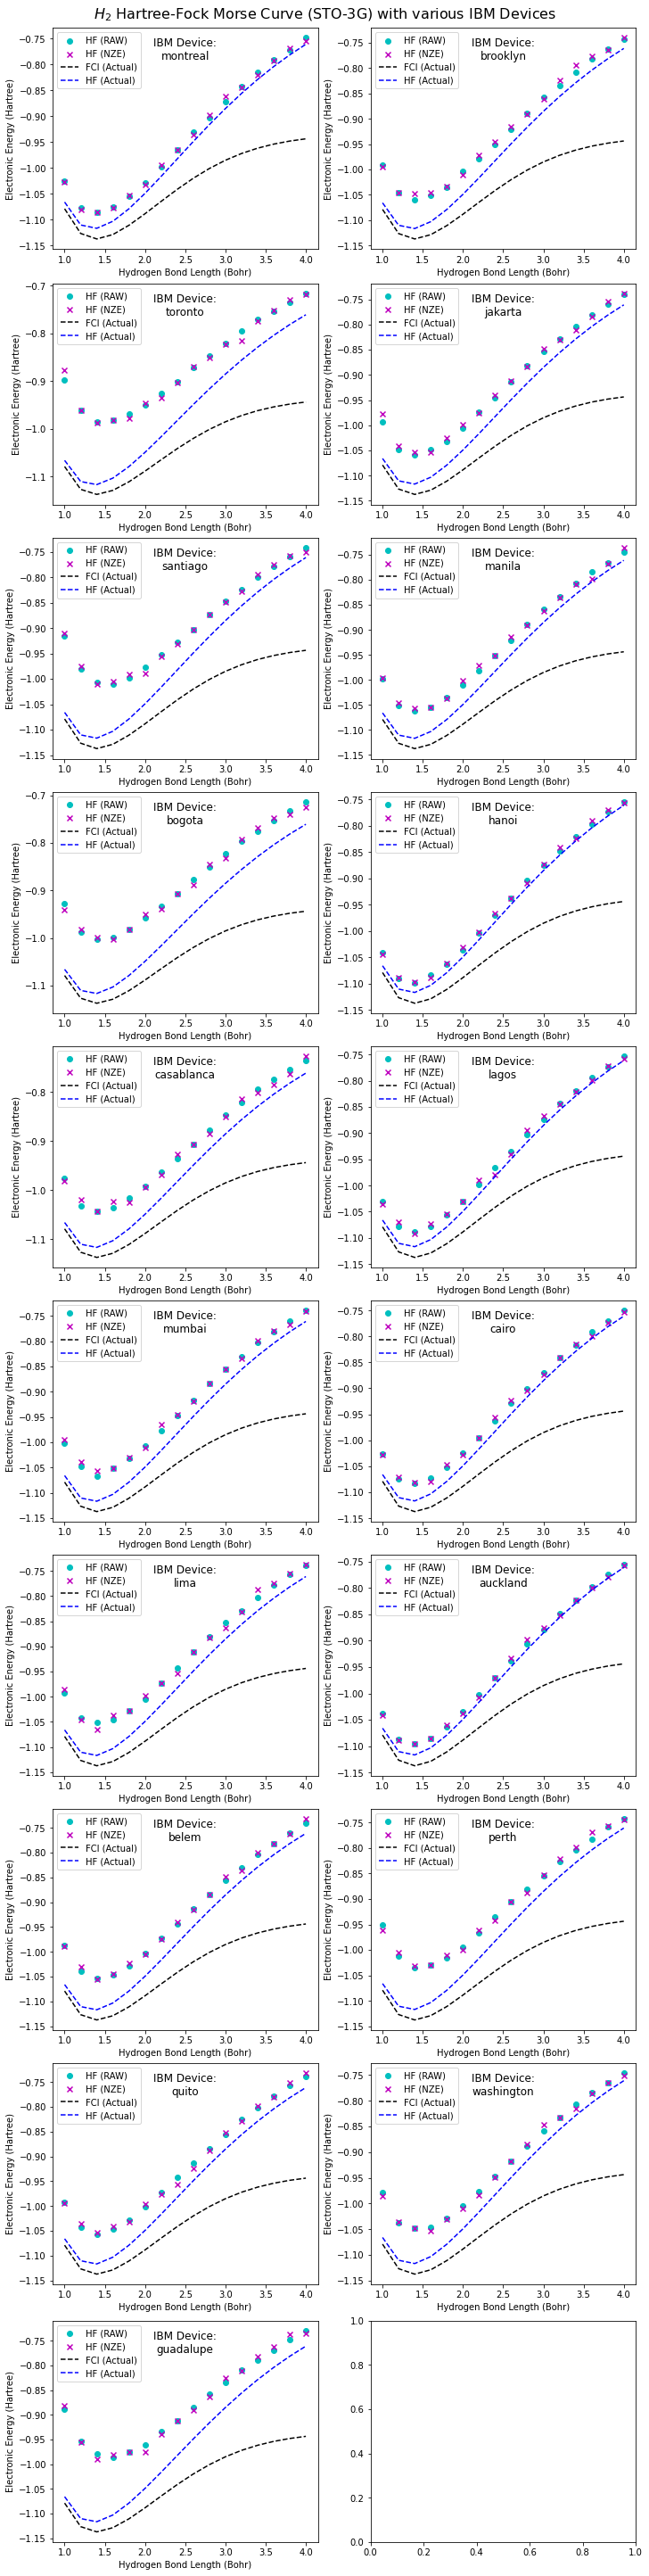

In [30]:
fig, ax = plt.subplots(10, 2, figsize=(10,40), constrained_layout=True)
fig.suptitle(r"$H_2$ Hartree-Fock Morse Curve (STO-3G) with various IBM Devices", fontsize=16)
for i in range(2):
    for j in range(10):
        if not((i==1) and (j==9)):
            device_name = 'IBM Device:\n' + backend_list[i*10+j].split("_")[1]
            ax[j][i].scatter(h2_opt_data['bond_length'], noisy_backend_noisy_morse[i*10+j], label='HF (RAW)', color='c')
            ax[j][i].scatter(h2_opt_data['bond_length'], mitig_noisy_backend_noisy_morse[i*10+j], label='HF (NZE)', color='m', marker='x')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['fci_ref_energy'], label='FCI (Actual)', color='k', ls='--')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['hf_ref_energy'], label='HF (Actual)', color='b',ls='--')
            ax[j][i].text(0.5,0.9,device_name,transform=ax[j][i].transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')
            ax[j][i].set_xlabel('Hydrogen Bond Length (Bohr)')
            ax[j][i].set_ylabel('Electronic Energy (Hartree)')
            ax[j][i].legend()

fig.savefig('h2_hf_morse_noisy_and_mitig.png',format='png')


### IBM Noise Models of Quantum Devices

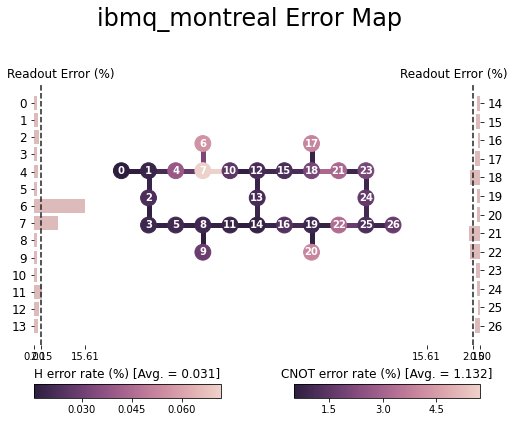

In [8]:
backend = provider.get_backend(backend_list[0])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

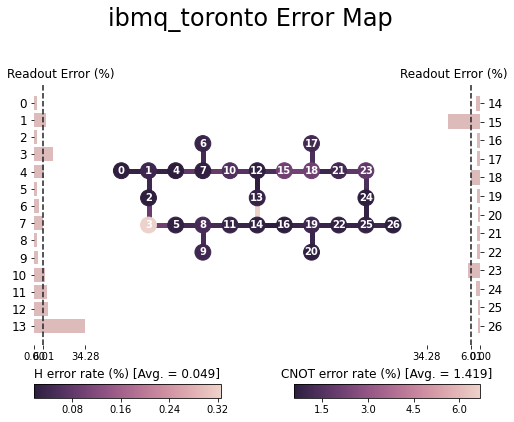

In [9]:
backend = provider.get_backend(backend_list[1])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

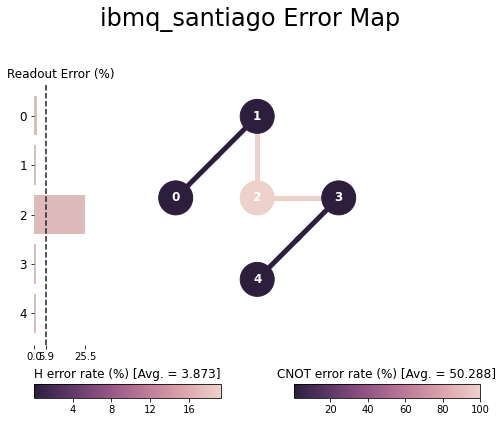

In [10]:
backend = provider.get_backend(backend_list[2])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

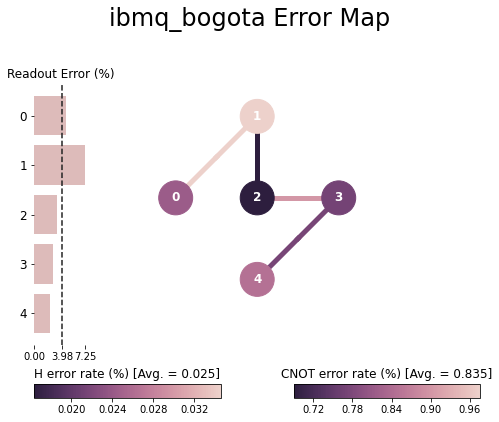

In [11]:
backend = provider.get_backend(backend_list[3])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

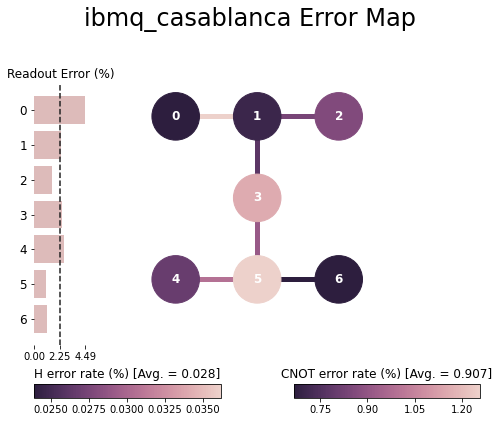

In [12]:
backend = provider.get_backend(backend_list[4])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

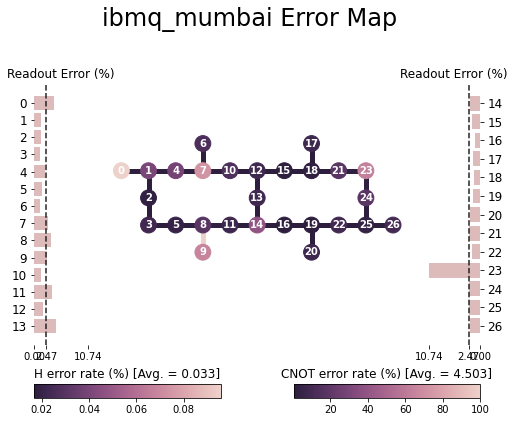

In [13]:
backend = provider.get_backend(backend_list[5])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

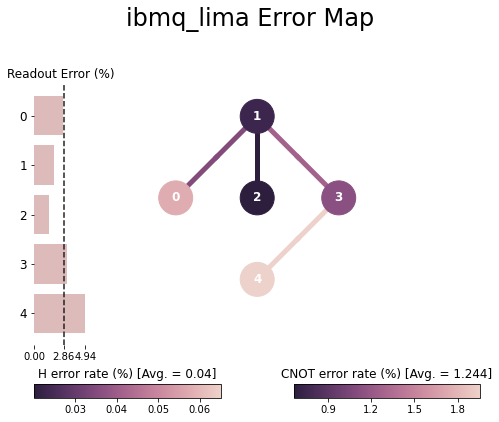

In [14]:
backend = provider.get_backend(backend_list[6])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

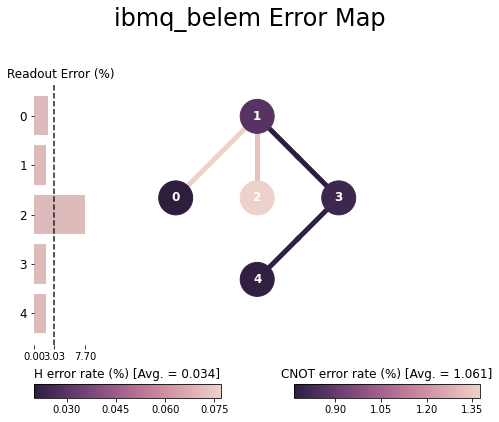

In [15]:
backend = provider.get_backend(backend_list[7])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

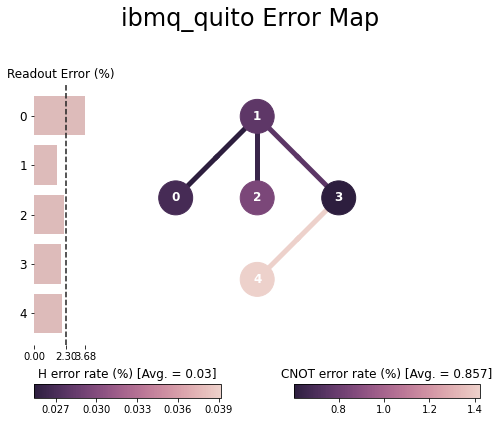

In [16]:
backend = provider.get_backend(backend_list[8])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

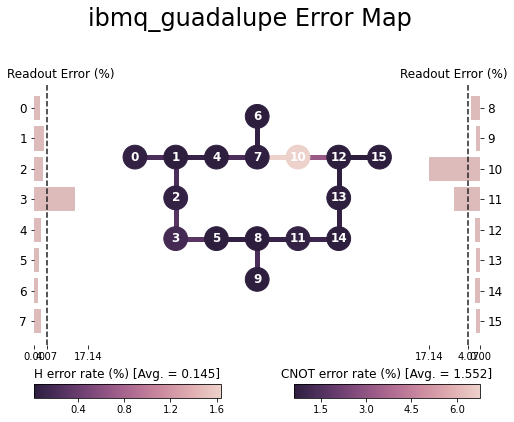

In [17]:
backend = provider.get_backend(backend_list[9])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

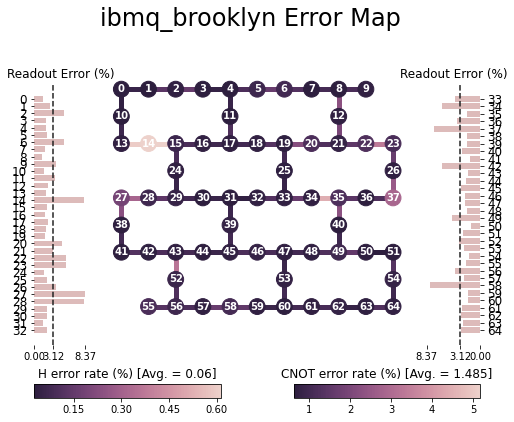

In [18]:
backend = provider.get_backend(backend_list[10])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

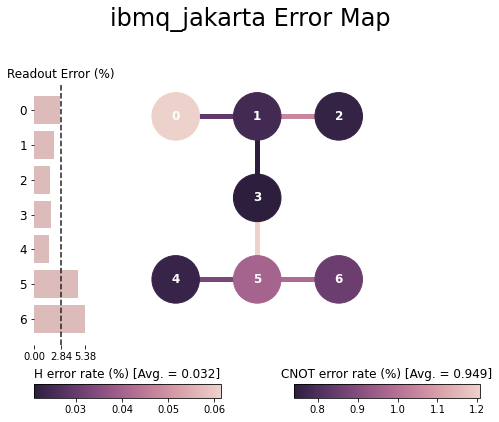

In [19]:
backend = provider.get_backend(backend_list[11])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

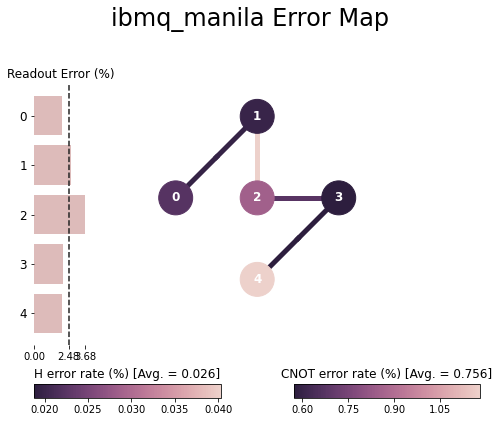

In [20]:
backend = provider.get_backend(backend_list[12])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

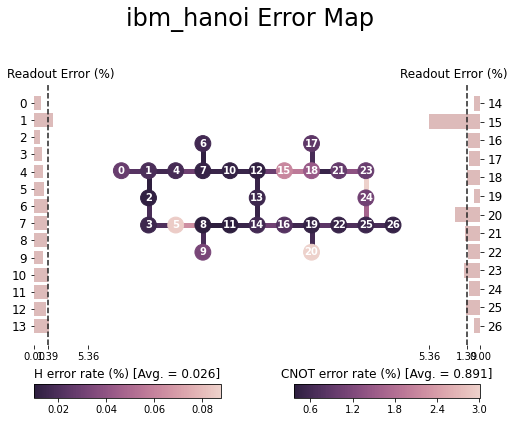

In [21]:
backend = provider.get_backend(backend_list[13])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

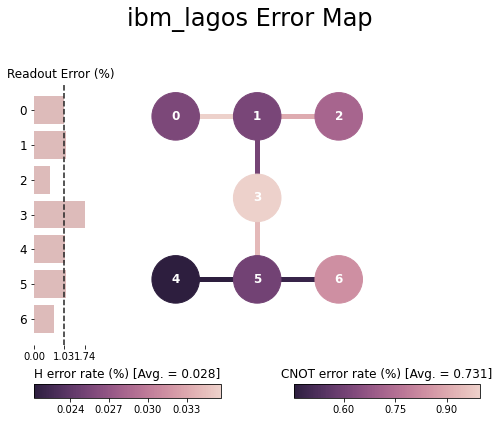

In [22]:
backend = provider.get_backend(backend_list[14])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

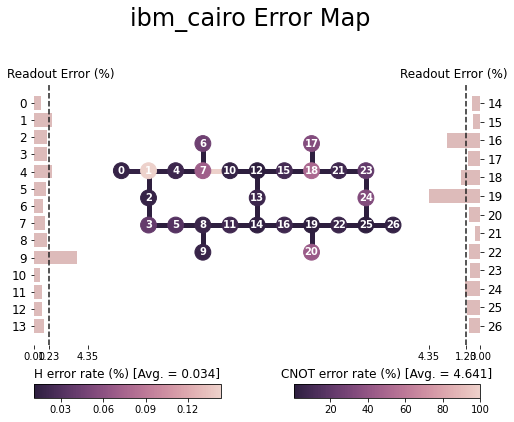

In [23]:
backend = provider.get_backend(backend_list[15])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

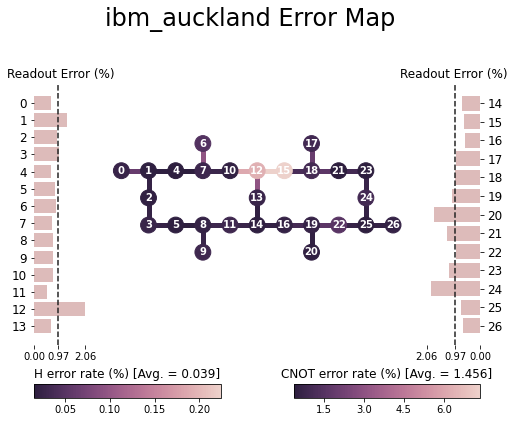

In [24]:
backend = provider.get_backend(backend_list[16])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

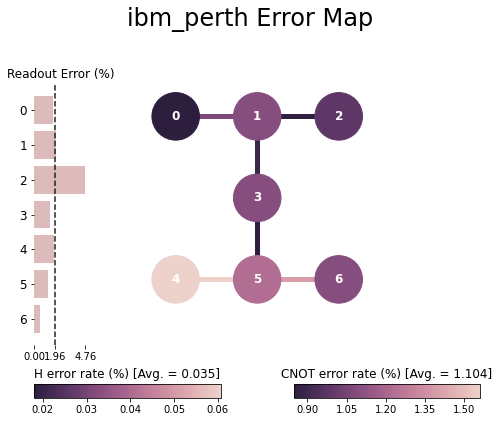

In [25]:
backend = provider.get_backend(backend_list[17])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

UnboundLocalError: local variable 'grid_data' referenced before assignment

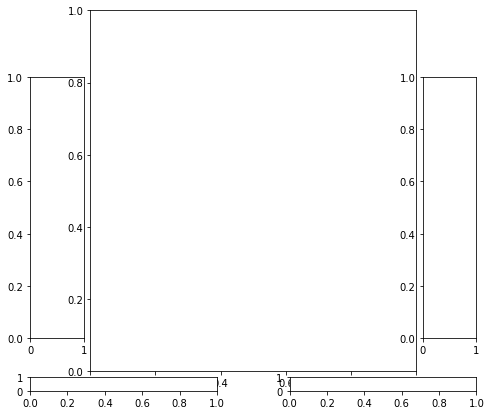

In [26]:
# This was supposed to be ibm_washington device
backend = provider.get_backend(backend_list[18])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

In [ ]:
# for i in range(len(backend_list)):
#     backend = provider.get_backend(backend_list[0])
#     fig2 = qiskit.visualization.plot_error_map(backend, figsize=(7,6))
#     fig2.savefig('h2_pi_'+backend_list[i].split("_")[1]+'.png',format='png')